#### Import / Global Vars

In [22]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [23]:
#imports section
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import cvxpy as cvx
import re, os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import *
from datetime import datetime, date, time, timedelta
from time import sleep
from mvo_utils_v2 import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [24]:
# L/S utility functions
# calculates max drawdown, largest reduction from highest point
def max_drawdown(xs):
    i = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
    j = np.argmax(xs[:i]) # start of period
    if log:
        plt.plot(xs)
        plt.plot([i, j], [xs[i], xs[j]], 'x', color='Red', markersize=10)
    return -1 * ((xs[j] - xs[i]) / xs[j])[0], j, i
# long-short version of recommend allocations
def ls_recommend_allocs(px, lb, net_exp, lev, min_w, max_w, gamma_val):
    px = clean_nas(px) # clean dataframe
    px_portion = px[-lb:].copy() # subselect the period to optimize; frame and lb were duplicatives
    returns, alloc = ls_get_weights(
        px_portion, lb, net_exp, lev, min_w, max_w, gamma_val) # subselect the period to optimize
    port_perf = calc_port_performance(returns.values, alloc.values)
    pdf = pd.DataFrame(port_perf, index=returns.index, columns=["Quantum"])
    return px_portion, returns, alloc, pdf
# long-short version of optimization, position weights
def ls_get_weights(px, lb, min_sum, max_sum, min_w, max_w, gamma_val):
    lb_rets = px.sort_index().pct_change().fillna(0) # capture the last lb days going back
    n = lb_rets.shape[1]; mu = lb_rets.mean().values.T; Sigma = lb_rets.cov().values
    w = cvx.Variable(n)
    gamma = cvx.Parameter(sign='positive')
    Lmax = cvx.Parameter()
    ret = mu.T * w; risk = cvx.quad_form(w, Sigma)
    lo_obj = cvx.Maximize(ret - gamma*risk)
    #lo_const = [cvx.sum_entries(w) >= min_sum, cvx.sum_entries(w) <= max_sum, w > min_w, w < max_w]
    ls_const = [cvx.sum_entries(w) >= min_sum, cvx.norm(w, 1) < Lmax, w <= max_w, w >= min_w]
    prob = cvx.Problem(lo_obj, ls_const)
    gamma.value = gamma_val; Lmax.value = max_sum
    prob.solve()
    weights = w.value if prob.status == 'optimal' else np.zeros((n, 1))
    np_weights = np.array(weights)
    lb_weights = pd.DataFrame(np_weights.T, index=[lb_rets.index[-1]], columns=lb_rets.columns)
    return lb_rets, lb_weights
# pending implementation using partials
def quick_gamma(glist, px, lb, net_exp, lev, min_w, max_w):
    if len(glist) <= 1: 
        mid_g = glist[0]
        mid_sr = get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, mid_g)
        return mid_g, mid_sr
    else:
        mid = len(glist)//2; left = glist[:mid]; right = glist[mid:]
        mid_l = left[len(left)//2]; mid_r = right[len(right)//2]
        left_sr = get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, mid_l)
        right_sr = get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, mid_r)
        sublist = left if left_sr > right_sr else right
        #if left_sr > right_sr: sublist = left
        #else: sublist = right
        return quick_gamma(sublist, px, lb, net_exp, lev, min_w, max_w)
# return portfolio sharpe for a given optimization
def get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, gamma):
    px_p, _, alloc, pdf = ls_recommend_allocs(px, lb, net_exp, lev, min_w, max_w, gamma)
    rec = last_allocation(alloc, 0.01)
    ret, risk = port_metrics(px_p, rec)
    return ret / risk
# cleans small positions in long-short portfolios based on minimum weight criteria
def filter_ls(rec, pos_filter):
    long = rec[(rec > pos_filter).values]; short = rec[(rec < -pos_filter).values]
    return long.append(short)
#calculates the historical allocations based on a date frequency
def get_hist_allocs(rebal_freq, px, lb, g_samples, min_len, pos_filter):
    px = clean_nas(px)
    as_of_idx = px.head(1).combine_first(px.asfreq(rebal_freq)).dropna()
    hist_allocs = pd.DataFrame([], index=as_of_idx.index)
    if log: print(len(as_of_idx.index), "rebalances"); print(as_of_idx.index)
    for d in as_of_idx.index:
        subset = px.loc[:d]; days = len(subset)
        if days < min_len: continue
        gamma_val, gamma_sr = quick_gamma(gamma_vals, subset, lb, net_exposure, leverage, min_weight, max_weight)
        if log: print("rebalancing: {0}, {1:.2f}, {2:.2f}".format(d, gamma_val, gamma_sr))
        px_portion, returns, alloc, pdf = ls_recommend_allocs(
            subset, lb, net_exposure, leverage, min_weight, max_weight, gamma_val)
        rec = last_allocation(alloc, min_weight)
        l_s = filter_ls(rec, pos_filter)
        hist_allocs = hist_allocs.combine_first(alloc[l_s.index])
    return hist_allocs
# alings allocations with trading days
def align_ret_allocs(allocs, px):
    rets = px[allocs.columns].pct_change().fillna(0)
    resampled_alloc = allocs.resample('D').pad()
    resampled_alloc = resampled_alloc.loc[rets.index]
    return rets, resampled_alloc
# explicit function to review global vars
def print_global_vars():
    global_vars_fmt = "Global Variables\n" \
    "Refresh Pricing: {}\n" + "Historical Time Window: {}\n" + "Lookback: {}\n" \
    + "Rebalance Frequency: {}\n" + "Net Exposure: {}\n" \
    + "Leverage: {}\n" + "Weights: min {} to max {}\n" + "Universe: {}\n"
    print(global_vars_fmt.format(
        refresh_pricing, hist_window, lookback, 
        rebal_frequency, net_exposure, 
        leverage, min_weight, max_weight,
        universe))

In [25]:
# Global variables
log = True
refresh_pricing = False
universe = 'spy-sectors' # 'spy_sectors OR 'ark_etfs'
active_etf = None # ETF name OR None for broad market

#variables for performance analysis
lookback = 60; net_exposure=0; leverage=1; min_weight=-0.05; max_weight=0.05 # default optimization vars
min_len = 3; pos_filter = 0.01 # cleaning variables
rebal_frequency = 'W-' + datetime.now().strftime('%a') # this is used during the historical allocations
gamma_vals = np.logspace(0.5, 2, num=100) # 1 to 100 range
print_global_vars()

Global Variables
Refresh Pricing: False
Historical Time Window: 3780
Lookback: 60
Rebalance Frequency: W-Mon
Net Exposure: 0
Leverage: 1
Weights: min -0.05 to max 0.05
Universe: spy-sectors



#### Load sector components from hard-drive

In [26]:
# load spy sector components
# would be nice to load a JSON with configuration
ticker_map = {
    'benchmark': ['SPY'],
    'equity': ['VTI','VTV','VOE','VBR','VEA','VWO'],
    'fixed_income': ['VTIP', 'SHV', 'MUB', 'LQD', 'BNDX', 'EMB'],
    'spy-sectors': ['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF', 'XLRE'],
    'ark-etfs': ['ARKG', 'ARKK', 'ARKQ', 'ARKW']
}

config = {
    'spy-sectors' : {
        'hold_cols': ['Symbol','Company Name', 'Index Weight'],
        'hold_format': r'holdings-spy-',
        'idx_col': 'Symbol',
        'fname': 'spy-sectors',
        'skiprows': 1
    },
    'ark-etfs' : {
        'hold_cols': ['ticker','company', 'weight(%)'],
        'hold_format': r'holdings-ark-',
        'idx_col': 'ticker',
        'fname': 'ark-etfs',
        'skiprows': 0
    }
}

hold_cols = config[universe]['hold_cols']
hold_format = config[universe]['hold_format']
idx_col = config[universe]['idx_col']
fname = config[universe]['fname']
skiprows = config[universe]['skiprows']

companies = load_components(
    companies, hold_format, hold_cols, 
    idx_col, ticker_map[universe], srows=skiprows)
print("Companies loaded:", companies.shape)
px_etfs = load_pricing(fname + '.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

Companies loaded: (505, 3)
Loaded pricing for spy-sectors.csv, with shape (2605, 10)
Loaded pricing for SPY.csv, with shape (2605, 1)


#### Get Data from the Server

In [27]:
# New approach using dynamic key lookup name
if refresh_pricing:
    etfs = [e for e in ticker_map[universe]]
    refresh_components(etfs)
    get_safe_pricing(universe + '.csv', ticker_map[universe], start_date)
    get_safe_pricing('SPY.csv', ['SPY'], start_date)
    px_etfs = load_pricing(universe + '.csv', 'Date')
    px_spy = load_pricing('SPY.csv', 'Date')

In [28]:
# Load pricing for components of each sectors
consol_px = clean_nas(load_consol_px(ticker_map, universe))
if(active_etf != None): companies = companies[companies['ETF']==active_etf] # filter by selected ETF
tickers = companies.index.tolist()
tickers=[i for i in tickers if i not in ['BF.b','BRK.b']] ## esta es una correcion extra para no incluir 'BF.b','BRK.b'
consol_px = consol_px[list(set(tickers))]

Loaded pricing for XLE-hold-pricing.csv, with shape (2605, 31)
Loaded pricing for XLU-hold-pricing.csv, with shape (2605, 28)
Loaded pricing for XLK-hold-pricing.csv, with shape (2605, 73)
Loaded pricing for XLB-hold-pricing.csv, with shape (2605, 25)
Loaded pricing for XLP-hold-pricing.csv, with shape (2605, 34)
Loaded pricing for XLY-hold-pricing.csv, with shape (2605, 82)
Loaded pricing for XLI-hold-pricing.csv, with shape (2605, 70)
Loaded pricing for XLV-hold-pricing.csv, with shape (2605, 61)
Loaded pricing for XLF-hold-pricing.csv, with shape (2605, 68)
Loaded pricing for XLRE-hold-pricing.csv, with shape (2605, 33)


#### Generate Trading Recomendations

In [29]:
# Removing tickers for M&A targets and diff class shares of same co.
remove_tickers = ['CSRA', 'DPS', 'UAA', 'DISCK', 'JUNO', 'XL', 'WELL', 'BKNG', 'SNI','EVGN', 'CBRE']
remove = list(set(remove_tickers).intersection(consol_px.columns.tolist()))
if len(remove) > 0: consol_px.drop(remove, axis=1, inplace=True)
consol_px.shape
consol_px = consol_px[sorted(consol_px.columns.tolist())]
consol_px.to_csv("consol_algo.csv")
consol_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2605 entries, 2007-11-16 to 2018-03-23
Columns: 495 entries, A to ZTS
dtypes: float64(495)
memory usage: 9.9 MB


In [10]:
# show the best net exposure (highest sharpe and lowest drawdown), recreates weekly balancing
log = False
time_frame = -60; rebal_frequency = 'W-WED'
subset = consol_px[time_frame:]

net_exposures = np.arange(0.0, 1.01, 0.1)
cols = ['Return', 'Risk', 'Sharpe', 'Return Spread', 'Max Drawdown']
perf_metrics = pd.DataFrame([], index=net_exposures, columns=cols)
perf_metrics.index.name = 'Net Exposure'
print_global_vars()

for ne in net_exposures:
    net_exposure = ne
    hist_allocs = get_hist_allocs(rebal_frequency, subset, lookback, gamma_vals, min_len, pos_filter)
    returns, allocs = align_ret_allocs(hist_allocs, consol_px)
    indexed_time_series = calc_port_performance(returns, allocs).to_frame()
    indexed_time_series.columns = ['Quantum']
    ret, risk, sr = portfolio_metrics('L/S', indexed_time_series)
    mdd, _, _ = max_drawdown(indexed_time_series.values)
    perf_metrics.loc[ne, perf_metrics.columns] = [ret, risk, sr, ret - risk, mdd]
perf_metrics = perf_metrics.sort_values(by='Return Spread', ascending=False)
perf_metrics

Global Variables
Refresh Pricing: False
Historical Time Window: 3780
Lookback: 60
Rebalance Frequency: W-WED
Net Exposure: 0.0
Leverage: 1
Weights: min -0.05 to max 0.05
Universe: spy-sectors



/Users/vicveiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/vicveiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


L/S Return: 0.15, StdDev: 0.06, Sharpe: 2.57
L/S Return: 0.11, StdDev: 0.05, Sharpe: 2.15
L/S Return: 0.10, StdDev: 0.05, Sharpe: 2.00
L/S Return: 0.12, StdDev: 0.06, Sharpe: 2.19
L/S Return: 0.12, StdDev: 0.06, Sharpe: 2.03
L/S Return: 0.09, StdDev: 0.06, Sharpe: 1.64
L/S Return: 0.12, StdDev: 0.07, Sharpe: 1.90
L/S Return: 0.11, StdDev: 0.07, Sharpe: 1.59
L/S Return: 0.10, StdDev: 0.07, Sharpe: 1.44
L/S Return: 0.11, StdDev: 0.08, Sharpe: 1.33
L/S Return: 0.10, StdDev: 0.09, Sharpe: 1.15


,Return,Risk,Sharpe,Return Spread,Max Drawdown
Net Exposure,,,,,
0.0,0.145474,0.056513,2.57418,0.0889615,-0.0357009
0.3,0.122564,0.0560021,2.18856,0.0665617,-0.0410817
0.4,0.120987,0.0594923,2.03366,0.0614945,-0.0432507
0.1,0.11027,0.0511945,2.15395,0.0590757,-0.037715
0.6,0.123827,0.0650182,1.9045,0.0588088,-0.0534366
0.2,0.104719,0.0522325,2.00487,0.052487,-0.0383771
0.7,0.11058,0.0695015,1.59105,0.0410786,-0.0612138
0.5,0.0949747,0.0580433,1.63627,0.0369314,-0.0471119
0.8,0.103892,0.0723343,1.43627,0.0315575,-0.0662659


In [30]:
# calculates optimal gamma
gamma_val, gamma_sr = quick_gamma(
    gamma_vals, consol_px, lookback, net_exposure, leverage, min_weight, max_weight)
gamma_val, gamma_sr

(27.50387840931946, 2.5662325054504183)

In [31]:
# run portfolio with best net exposure
min_gross = perf_metrics.index[0] # updates with best net exposure
print_global_vars()
px_portion, returns, alloc, pdf = ls_recommend_allocs(
    consol_px, lookback, net_exposure, leverage, min_weight, max_weight, gamma_val)
rec = last_allocation(alloc, min_weight)
recommend = filter_ls(rec, pos_filter)
tickers = recommend.index.tolist()

Global Variables
Refresh Pricing: False
Historical Time Window: 3780
Lookback: 60
Rebalance Frequency: W-Mon
Net Exposure: 0
Leverage: 1
Weights: min -0.05 to max 0.05
Universe: spy-sectors



In [32]:
cos_no_dup = companies.drop_duplicates(subset='Company')
recommend['Sector'] = cos_no_dup.loc[tickers]['ETF']
recommend['Company'] = cos_no_dup.loc[tickers][['Company']]
recommend = recommend.astype({"Allocation": np.float})
recommend[['Company', 'Sector', 'Allocation']]
# esto debe estar dentro de portfolio metrics
print("{} Positions, {} Long, {} Short, Long Exposure: {}, Short Exposure {}".format(
    len(recommend.index), 
    len(recommend[recommend['Allocation'] > 0]), 
    len(recommend[recommend['Allocation'] < 0 ]),
    recommend[recommend['Allocation'] > 0]['Allocation'].sum(),
    recommend[recommend['Allocation'] < 0]['Allocation'].sum())
     )
recommend

24 Positions, 11 Long, 13 Short, Long Exposure: 0.469410890235591, Short Exposure -0.48130027523859137


,Allocation,Sector,Company
AMZN,0.050000,XLY,Amazon.com Inc
APC,0.050000,XLE,Anadarko Petroleum Corp
EW,0.015275,XLV,Edwards Lifesciences Corp
GWW,0.026321,XLI,Grainger W.W. Inc
IDXX,0.050000,XLV,IDEXX Laboratories Inc
MU,0.050000,XLK,Micron Technology Inc
NFLX,0.050000,XLY,NetFlix Inc
NKTR,0.050000,XLV,Nektar Therapeutics
RHT,0.050000,XLK,Red Hat Inc
STX,0.050000,XLK,Seagate Technology


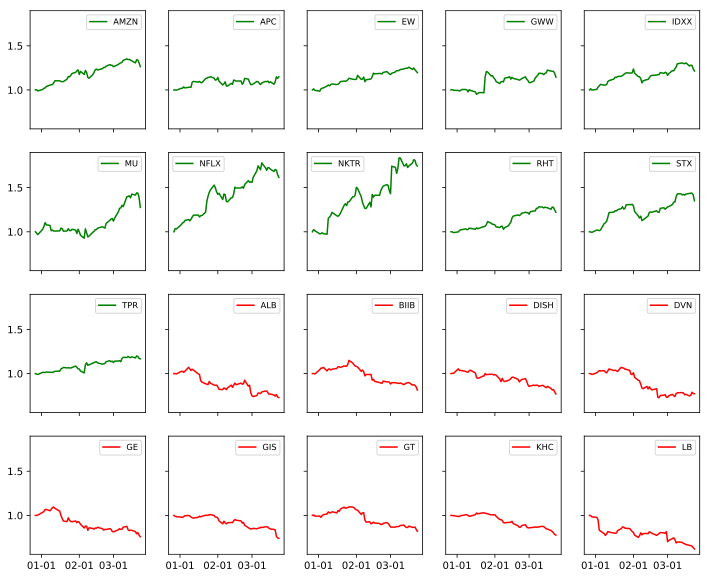

In [33]:
# plots all tickers to verify if there are any M&A targets
nbr_charts = len(sorted(tickers)); cols = 5
fig, ax = plt.subplots(nbr_charts // cols, cols, figsize=(12,10), sharex=True, sharey=True)
# fig -> set fig spacing and general properties
for i, axi in enumerate(ax.flat):
    co = tickers[i]
    df_range = compound(consol_px[co][-lookback:])
    weight = recommend.loc[co]['Allocation']
    color = '-g' if weight > 0 else '-r'
    axi.plot(df_range.index.to_datetime().tolist(), df_range.values, color, label=df_range.name)
    axi.legend(fontsize='small')
    #axi.yaxis.set_major_locator(plt.NullLocator())
    axi.xaxis.set_major_locator(mdates.MonthLocator())
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

In [34]:
sect_group_stats(recommend, 'Sector').sort_values(by='Sector Weight', ascending=False)

Total % Allocation -1.19


,Sector Weight,Avg Position
XLK,0.150000,0.050000
XLV,0.043328,0.008666
XLY,0.036037,0.006006
XLI,-0.023679,-0.011839
XLF,-0.025850,-0.025850
XLB,-0.032797,-0.032797
XLE,-0.058928,-0.014732
XLP,-0.100000,-0.050000


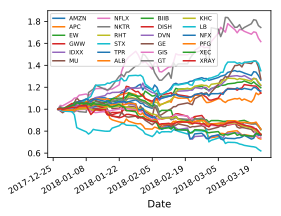

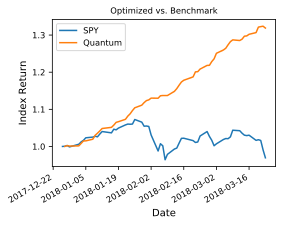

In [42]:
ax = compound(consol_px[recommend.index][-lookback:]).plot(fontsize='small', figsize=(4,3))
ax.legend(fontsize='xx-small', ncol=4)
idx = px_spy.iloc[-(len(pdf.index)+1):].index
idx_px_spy = compound(px_spy.loc[idx])
plot_two_series(idx_px_spy, pdf, 'SPY', 'Quantum', 'Date', 'Index Return', 'Optimized vs. Benchmark')
# need to add 1 at the begining of pdf

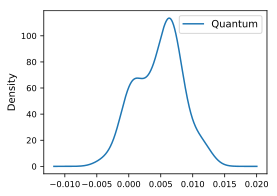

In [44]:
pdf.pct_change().plot(kind='kde', figsize=(4,3), fontsize='small')

In [51]:
# Outputs for trade execution
px = consol_px[tickers][-lookback:]
date = px[-1:].index.to_datetime().strftime(date_fmt)[0]
ret, risk = port_metrics(px_portion, rec)

trading_cols = ['Company', 'Price', 'Allocation', 'Dollar Value', 'Shares']
trading_df = pd.DataFrame([], index=recommend.index, columns=trading_cols)

round_shares = lambda x: round(x, 0)
port_bal = 222000; alloc = recommend['Allocation']
pvalue = (port_bal * alloc)
shares = (port_bal * alloc) / px[-1:]
shares.apply(round_shares).T.sort_index()

trading_df['Company'] = recommend['Company']
trading_df['Price'] = px[-1:].T
trading_df['Allocation'] = recommend['Allocation']
trading_df['Dollar Value'] = trading_df['Allocation'] * port_bal
trading_df['Shares'] = trading_df['Dollar Value'] / trading_df['Price']

print_global_vars()
print("Ann. Ret: {0:.2f}, Risk: {1:.2f} Sharpe: {2:.2f}".format(ret, risk, ret / risk))
print("{} Positions, {} Long, {} Short, Long Exposure: {}, Short Exposure {}".format(
    len(recommend.index), 
    len(recommend[recommend['Allocation'] > 0]), 
    len(recommend[recommend['Allocation'] < 0 ]),
    recommend[recommend['Allocation'] > 0]['Allocation'].sum(),
    recommend[recommend['Allocation'] < 0]['Allocation'].sum())
     )

print("Date: {0}, Net Dollar Exposure: {1:.2f}, Total Allocation: {2:.2f}%".format(date, trading_df['Dollar Value'].sum(), trading_df['Allocation'].sum() * 100))
trading_df.head()
trading_df = trading_df.astype({'Dollar Value':np.int, 'Shares':np.int})

if refresh_pricing:
    fname = datetime.now().strftime(universe + '_' + date_fmt + r'_%H-%M') + '.csv'
    trading_df.to_csv(fname)
    print('Saved portfolio rebalance:', fname)
trading_df.sort_index()

Global Variables
Refresh Pricing: False
Historical Time Window: 3780
Lookback: 60
Rebalance Frequency: W-Mon
Net Exposure: 0
Leverage: 1
Weights: min -0.05 to max 0.05
Universe: spy-sectors

Ann. Ret: 0.28, Risk: 0.03 Sharpe: 10.25
24 Positions, 11 Long, 13 Short, Long Exposure: 0.469410890235591, Short Exposure -0.48130027523859137
Date: 2018-03-23, Net Dollar Exposure: -2639.44, Total Allocation: -1.19%


,Company,Price,Allocation,Dollar Value,Shares
ALB,Albemarle Corp,93.239998,-0.032797,-7281,-78
AMZN,Amazon.com Inc,1495.560059,0.050000,11099,7
APC,Anadarko Petroleum Corp,61.560001,0.050000,11099,180
BIIB,Biogen Inc,260.130005,-0.021947,-4872,-18
DISH,DISH Network Corp A,36.650002,-0.019430,-4313,-117
DVN,Devon Energy Corp,32.230000,-0.029186,-6479,-201
EW,Edwards Lifesciences Corp,135.320007,0.015275,3391,25
GE,General Electric Co,13.070000,-0.050000,-11099,-849
GIS,General Mills Inc,44.209999,-0.050000,-11099,-251
GT,Goodyear Tire & Rubber Co,26.610001,-0.022348,-4961,-186


#### Utility Cells (move to separate file)

In [248]:
weights = np.zeros((len(consol_px.columns), 1))
np_weights = np.array(weights)
lb_rets = consol_px.sort_index().pct_change().dropna()
lb_weights = pd.DataFrame(np_weights.T, index=[lb_rets.index[-1]], columns=lb_rets.columns)

In [188]:
# illustration of how two allocation frames can be combined
df1 = pd.DataFrame(np.arange(0,6,1).reshape(2,3), index=[1,2], columns=list('abc'))
df2 = pd.DataFrame(np.arange(6,12,1).reshape(2,3), index=[1,2], columns=list('cde'))
df1.combine_first(df2)

,a,b,c,d,e
1,0,1,2,7.0,8.0
2,3,4,5,10.0,11.0


In [189]:
# illustration of how two allocation frames can be combined
df1 = pd.DataFrame(np.arange(0,6,1).reshape(2,3), index=[1,2], columns=list('abc'))
df2 = pd.DataFrame(np.arange(6,12,1).reshape(2,3), index=[3,4], columns=list('cde'))
df1.combine_first(df2)

,a,b,c,d,e
1,0.0,1.0,2.0,NaN,NaN
2,3.0,4.0,5.0,NaN,NaN
3,NaN,NaN,6.0,7.0,8.0
4,NaN,NaN,9.0,10.0,11.0
